In [1]:
!nvidia-smi

Sat Jan 25 11:49:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:1A:00.0 Off |                  N/A |
| 30%   48C    P2    95W / 250W |   4959MiB / 11019MiB |     40%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:1B:00.0 Off |                  N/A |
| 30%   25C    P8    21W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
# from tensorflow.keras.models import load_model
from scipy import stats
# import tensorflow as tf
import math
import itertools
import operator
# from tensorflow.python.keras import backend as k
from tqdm import tqdm, tqdm_notebook, notebook
import numpy as np
# from tensorflow.keras import layers
import os
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
import random
from random import choice
import re

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle

from sklearn.preprocessing import LabelEncoder
from bio import AlignIO
# from Bio.Align import MultipleSeqAlignment
# from Bio.SeqRecord import SeqRecord
# from Bio import SeqIO
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import sklearn
import numpy as np
import re
import pickle
import itertools
import random
import string
from joblib import dump, load

%precision 2

# os.environ["CUDA_VISIBLE_DEVICES"]="7"
context_length = 15
val_loss_hist = []

# K.clear_session()
# keras.backend.clear_session()

ancName = '_HPGPNRMPCCSO'
desName = 'hg38'

anc = str(np.load('prepData/insert2Anc_{}_hg38_chr3.npy'.format(ancName)))[:10000000]
des = str(np.load('prepData/insert2Des_{}_hg38_chr3.npy'.format(ancName)))[:10000000]
anc = np.array(list(anc+'0'))
des = np.array(list(des+'0'))

# with open('label_encoder.pickle', 'rb') as f:
#     label_encoder = pickle.load(f)
# with open('onehot_encoder.pickle', 'rb') as f:
#     onehot_encoder = pickle.load(f)

label_encoder = load('label_encoder.joblib') 
onehot_encoder = load('onehot_encoder.joblib') 

integer_encoded_des = label_encoder.transform(des)
integer_encoded_anc = label_encoder.transform(anc)
integer_des = integer_encoded_des.reshape(len(integer_encoded_des), 1)
encoded_des =onehot_encoder.transform(integer_des)
integer_anc = integer_encoded_anc.reshape(len(integer_encoded_anc), 1)
encoded_anc = onehot_encoder.transform(integer_anc)

print(encoded_des)
print(encoded_anc)

print(len(encoded_des[0]))
encode_dimension= len(encoded_des[0])

print(label_encoder.inverse_transform(range(encode_dimension)))
print(onehot_encoder.transform(np.ones(1).reshape(-1,1)))
key = list(label_encoder.inverse_transform(range(encode_dimension)))

nucleotide = label_encoder.inverse_transform(range(encode_dimension))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
86
['!' '"' '$' '%' '&' '(' ')' '*' '+' '-' '.' '/' '0' '1' '2' '3' '4' '5'
 '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' '@' 'A' 'B' 'C' 'D' 'E' 'F' 'G'
 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 '[' '\\' ']' '^' '_' '`' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'l' 'm'
 'n' 'o' 'p' 'q' 's' 't' 'u' 'w' 'x' 'z' '{' '|' '}' '~']
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [5]:
def load_seq(chromList):
    inputAll = ''
    predAll = ''
    outputAll = ''
    for chromosome in chromList:
        try:
            inputAll += str(np.load('prepData/insert2Anc_{}_hg38_chr{}.npy'.format(ancName,chromosome)))#[:10000000]
            outputAll += str(np.load('prepData/insert2Des_{}_hg38_chr{}.npy'.format(ancName,chromosome)))#[:10000000]
            predAll += str(np.load('prepData/simulated_{}_-1_chr{}.npy'.format(ancName, chromosome)))#[:10000000]
        except FileNotFoundError:
            print(chromosome)
            continue
        print(len(inputAll), len(outputAll), len(predAll))
        print(inputAll[-10:], outputAll[-10:], predAll[-10:])
    return [inputAll], [outputAll], [predAll]

# def load_seq(chromList):
#     inputAll = ''
#     predAll = ''
#     outputAll = ''
#     for chromosome in chromList:
#         inputAll += str(np.load('prepData/insert2Anc_{}_hg38_chr{}.npy'.format(ancName,chromosome)))[:10000000]
#         outputAll += str(np.load('prepData/insert2Des_{}_hg38_chr{}.npy'.format(ancName,chromosome)))[:10000000]
#         predAll += str(np.load('simulated_{}_10000000_chr{}.npy'.format(ancName, chromosome)))[:10000000]
#     return [inputAll], [outputAll], [predAll]
    
mut_dict = np.load('mut_dict_insert2.npy',allow_pickle=True).item()
inv_dict = {v: k for k, v in mut_dict.items()}
print(inv_dict)

inputAll, outputAll, predAll = load_seq([12,16,17,19,20,21,22])

{'A': 'A', 'C': 'C', 'G': 'G', 'T': 'T', '-': '-', '0': '0', '^': 'AAA', 'f': 'AAC', '4': 'AAT', 'B': 'AAG', 'w': 'ACA', 't': 'ACC', 'i': 'ACT', 'e': 'ACG', '.': 'ATA', 'c': 'ATC', '>': 'ATT', 'X': 'ATG', '5': 'AGA', '|': 'AGC', '[': 'AGT', 's': 'AGG', 'u': 'CAA', '(': 'CAC', '=': 'CAT', 'q': 'CAG', 'W': 'CCA', '_': 'CCC', '!': 'CCT', '{': 'CCG', '1': 'CTA', 'Q': 'CTC', 'U': 'CTT', 'b': 'CTG', 'M': 'CGA', ';': 'CGC', 'm': 'CGT', '~': 'CGG', 'a': 'TAA', ']': 'TAC', '&': 'TAT', ')': 'TAG', '7': 'TCA', '6': 'TCC', 'p': 'TCT', '%': 'TCG', 'n': 'TTA', 'P': 'TTC', 'F': 'TTT', 'h': 'TTG', '3': 'TGA', ':': 'TGC', 'z': 'TGT', '8': 'TGG', 'R': 'GAA', 'S': 'GAC', '/': 'GAT', 'j': 'GAG', 'o': 'GCA', 'd': 'GCC', '@': 'GCT', 'L': 'GCG', '}': 'GTA', 'H': 'GTC', 'Y': 'GTT', 'x': 'GTG', '"': 'GGA', 'I': 'GGC', '\\': 'GGT', 'J': 'GGG', '9': 'AA', '`': 'AC', 'l': 'AT', '<': 'AG', 'N': 'CA', 'V': 'CC', 'D': 'CT', '+': 'CG', 'E': 'TA', 'Z': 'TC', '$': 'TT', '?': 'TG', '2': 'GA', 'K': 'GC', '*': 'GT', 'g': 

In [11]:

# decoded_seq = str(np.load('simulated_{}_10000000_chr{}.npy'.format(ancName, chromosome)))
# inputAll =[''.join(anc)[:-1]]
# predAll = [decoded_seq[:-1]]
# outputAll = [''.join(des)[:-1]

lstm_inputAll = [''.join(anc)[:2000000]]
lstm_predAll = [str(np.load('simulated_{}_lstm.npy'.format(ancName)))]
lstm_outputAll = [''.join(des)[:2000000]]
contextLen = 2
numBin = 10
def contextMut(size, ancNuc, desNuc, anc, des, pred, evol, lstm = False, table='', tableCon=0):
    cont = list(itertools.product('ACGT', repeat=size))
    cont1 = list(itertools.product('ACGT', repeat=size))
    context_dict = {}
    count_dict = {}
    for i in cont1:
        for j in cont1:
            #context_dict[(''.join(i)+'A'+''.join(j) , ''.join(i)+'G'+''.join(j))] = 0
            context_dict[(''.join(i)+ancNuc+''.join(j))] = 0
            count_dict[(''.join(i)+ancNuc+''.join(j))] = 0
    for a,b in zip(anc, des):
        for i in range(len(a)-size*2-len(ancNuc)):
            if a[i+size:i+size+len(ancNuc)] == ancNuc :
                count_dict[(a[i:i+size*2+len(ancNuc)])] += 1
    for a,b in zip(anc, des):
        for i in range(len(a)-size*2-len(ancNuc)):
            if a[i+size:i+size+len(ancNuc)] == ancNuc and b[i+size+int(len(ancNuc)/2)] == desNuc:
                context_dict[(a[i:i+size*2+len(ancNuc)])] += 1
    for key in context_dict.keys():
        if count_dict[key] !=0:
            context_dict[key] = context_dict[key]/count_dict[key] 
        else :
            continue
    sorted_context = sorted(context_dict.items(), key=operator.itemgetter(1), reverse = 1)
    sorted_context = dict(sorted_context)
    if lstm ==False:
        if pred == True and evol ==False:
            np.save('data/pred{}_context{}->{}_{}_{}.npy'.format(table,ancNuc,desNuc,ancName,tableCon), sorted_context)
        elif pred == True and evol == True:
            np.save('data/pred{}_evol_context{}->{}_{}_{}.npy'.format(table,ancNuc,desNuc,ancName,tableCon), sorted_context)
        elif pred == False and evol ==False:
            np.save('data/true_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), sorted_context)
        elif pred == False and evol ==True:
            np.save('data/true_evol_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), sorted_context)
        return sorted_context
    elif lstm ==True :
        if pred == True:
            np.save('data/pred_lstm_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), sorted_context)
        elif pred ==False:
            np.save('data/true_lstm_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), sorted_context)
    return sorted_context
            
def contextMutInsert(size, ancNuc, desNuc, anc, des, pred, evol, lstm = False, table = '', tableCon=0):
    cont1 = list(itertools.product('ACGT', repeat=size-1))
    cont = list(itertools.product('ACGT', repeat=size))
    context_dict = {}
    count_dict = {}
    for i in cont:
        for j in cont:
            #context_dict[(''.join(i)+'A'+''.join(j) , ''.join(i)+'G'+''.join(j))] = 0
            context_dict[(''.join(i)+ancNuc+''.join(j))] = 0
            count_dict[(''.join(i)+ancNuc+''.join(j))] = 0
    for a,b in zip(anc, des):
        for i in range(len(a)-size*2-len(ancNuc)):
            count_dict[(a[i:i+size]+ancNuc+a[i+size+len(ancNuc):i+size*2+len(ancNuc)])] += 1
    for a,b in zip(anc, des):
        for i in range(len(a)-size*2-len(ancNuc)):
            inserted_nuc = inv_dict[b[i+size+int(len(ancNuc)/2)-1]]
            if len(inserted_nuc) >1 and inserted_nuc[1] == desNuc:
                context_dict[(a[i:i+size]+ancNuc+a[i+size+len(ancNuc):i+size*2+len(ancNuc)])] += 1
    for key in context_dict.keys():
        if count_dict[key] !=0:
            context_dict[key] = context_dict[key]/count_dict[key] 
        else :
            continue
    sorted_context = sorted(context_dict.items(), key=operator.itemgetter(1), reverse = 1)
    sorted_context = dict(sorted_context)
    if lstm ==False:
        if pred == True and evol ==False:
            np.save('data/pred{}_context{}->{}_{}_{}.npy'.format(table,ancNuc,desNuc,ancName,tableCon), sorted_context)
        elif pred == True and evol == True:
            np.save('data/pred{}_evol_context{}->{}_{}_{}.npy'.format(table,ancNuc,desNuc,ancName,tableCon), sorted_context)
        elif pred == False and evol ==False:
            np.save('data/true_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), sorted_context)
        elif pred == False and evol ==True:
            np.save('data/true_evol_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), sorted_context)
        return sorted_context
    elif lstm ==True :
        if pred == True:
            np.save('data/pred_lstm_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), sorted_context)
        elif pred ==False:
            np.save('data/true_lstm_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), sorted_context)
    return sorted_context
            
def decodeList(inputAll, predAll, outputAll):
    inp =[]
    inp2 = []
    pre = []
    out = []
    for i, p, o in tqdm(zip(inputAll, predAll, outputAll)):
        input, pred = decodeDictSeq(i, p, mut_dict)
        input2, output = decodeDictSeq(i,o, mut_dict)
        inp.append(input)
        inp2.append(input2)
        pre.append(pred)
        out.append(output)
    return inp, inp2, pre, out

def valueFloat(data_list):
    newDict = dict(zip(data_list.keys(), [float(value) for value in data_list.values()]))
    return newDict
def plotPointMut(n_groups,ancNuc, desNuc):
    predSeq = np.load('data/pred_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()

    trueSeq = np.load('data/true_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()

#     evolSeq = np.load('data/true_evol_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()
    
    lstmSeq = np.load('data/pred_lstm_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()

    true = list(trueSeq.values())[:n_groups]
    true_context = list(trueSeq.keys())[:n_groups]
    pred = []
    evol = []
    lstm = []
    for i in true_context:
        pred.append(predSeq[i])
#         evol.append(evolSeq[i])
        lstm.append(lstmSeq[i])

    # create plot
    fig, ax = plt.subplots(figsize=(20, 10))
    index = np.arange(n_groups)
    bar_width = 0.05
    opacity = 0.8

    rects1 = plt.bar(index, pred, bar_width,
    alpha=opacity,
    color='b',
    label='seq2seq_pred')
    
    rects2 = plt.bar(index + bar_width, lstm, bar_width,
    alpha=opacity,
    color='m',
    label='lstm_pred')
    
    rects3 = plt.bar(index + bar_width*2, true, bar_width,
    alpha=opacity,
    color='g',
    label='true')
    
#     rects3 = plt.bar(index + bar_width*3, evol, bar_width,
#     alpha=opacity,
#     color='r',
#     label='evol_pred')

    plt.xlabel('context')
    plt.ylabel('rate')
    plt.title('{} to {} point mutation'.format(ancNuc, desNuc))
    plt.xticks(index + bar_width, list(trueSeq.keys())[:n_groups])
    plt.legend()

    #plt.tight_layout()
    plt.show()
    plt.close()

def plotScatter(n_groups, ancNuc, desNuc, tableCon):
    predSeq = np.load('data/pred_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()

    tableSeq = np.load('data/predTable_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()
    
    trueSeq = np.load('data/true_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()

#     evolSeq = np.load('data/true_evol_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()
    
    lstmSeq = np.load('data/pred_lstm_context{}->{}_{}_{}.npy'.format(ancNuc,desNuc,ancName,tableCon), allow_pickle = True).item()

    true = list(trueSeq.values())
    true_context = list(trueSeq.keys())
    pred = []
    evol = []
    lstm = []
    table = []
    for i in true_context:
        pred.append(predSeq[i])
#         evol.append(evolSeq[i])
        lstm.append(lstmSeq[i])
        table.append(tableSeq[i])
        
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
    f.text(0.5, 0.0, 'Observed', ha='center', va='center', fontsize = 16)
    f.text(0.05, 0.5, 'Predicted', ha='center', va='center', rotation='vertical', fontsize = 16)
    
    ax1.scatter(true, table, color = 'y', label = 'freqTable')

#     ax1.axis('scaled')
#     ax1.axis('square')
    ax1.set_xlim([0, 1.2 * max(max(table), max(true))])
    ax1.set_ylim([0, 1.2 * max(max(table), max(true))])
    ax1.text(0.5,-0.1, "r = {}".format(stats.pearsonr(table, true)[0]), size=12, ha="center", 
                         transform=ax1.transAxes)
    ax1.set_title('xy{}zw to xy{}zw point mutation'.format(ancNuc, desNuc))
    for i, txt in enumerate(list(trueSeq.keys())):
        if i%30 == 0:
            ax1.annotate(txt, (true[i], table[i]))

    ax1.legend()
    
    
    ax2.scatter(true, lstm, color = 'k', label = 'lstm')
    for i, txt in enumerate(list(lstmSeq.keys())):
        if i%30 == 0:
            ax2.annotate(txt, (true[i], lstm[i]))

#     ax2.axis('scaled')
#     ax2.axis('square')
    ax2.set_xlim([0, 1.2 * max(max(lstm), max(true))])
    ax2.set_ylim([0, 1.2* max(max(lstm), max(true))])
    ax2.text(0.5,-0.1, "r = {}".format(stats.pearsonr(lstm, true)[0]), size=12, ha="center", 
                             transform=ax2.transAxes)
    ax2.legend()
    ax2.set_title('xy{}zw to xy{}zw point mutation'.format(ancNuc, desNuc))
    
    ax3.scatter(true, pred, color = 'm', label = 'DeepEvoLstm')

#     ax3.axis('scaled')
#     ax3.axis('square')
    ax3.set_xlim([0, 1.2 * max(max(pred), max(true))])
    ax3.set_ylim([0, 1.2 * max(max(pred), max(true))])
    ax3.text(0.5,-0.1, "r = {}".format(stats.pearsonr(pred, true)[0]), size=12, ha="center", 
                         transform=ax3.transAxes)
    ax3.set_title('xy{}zw to xy{}zw point mutation'.format(ancNuc, desNuc))
    for i, txt in enumerate(list(trueSeq.keys())):
        if i%30 == 0:
            ax3.annotate(txt, (true[i], pred[i]))

    ax3.legend()
    
    f.savefig('figures/scatter_{}_{}_{}->{}_{}.png'.format(ancName, desName,  ancNuc, desNuc, tableCon))
    f.show()
    plt.show()
    plt.close()
#     print(stats.pearsonr(pred, true), stats.pearsonr(lstm, true))
    return ('{} $rightarrow$ {} & {:.3f} & {:.3f} & {:.3f}'.format(ancNuc, desNuc,stats.pearsonr(pred, true)[0], stats.pearsonr(lstm, true)[0], stats.pearsonr(table, true)[0] ))
            

# np.save('inputAll_{}_{}'.format(ancName, desName), inputAll)
# np.save('predAll_{}_{}'.format(ancName, desName), predAll)
# np.save('outputAll_{}_{}'.format(ancName, desName), outputAll)

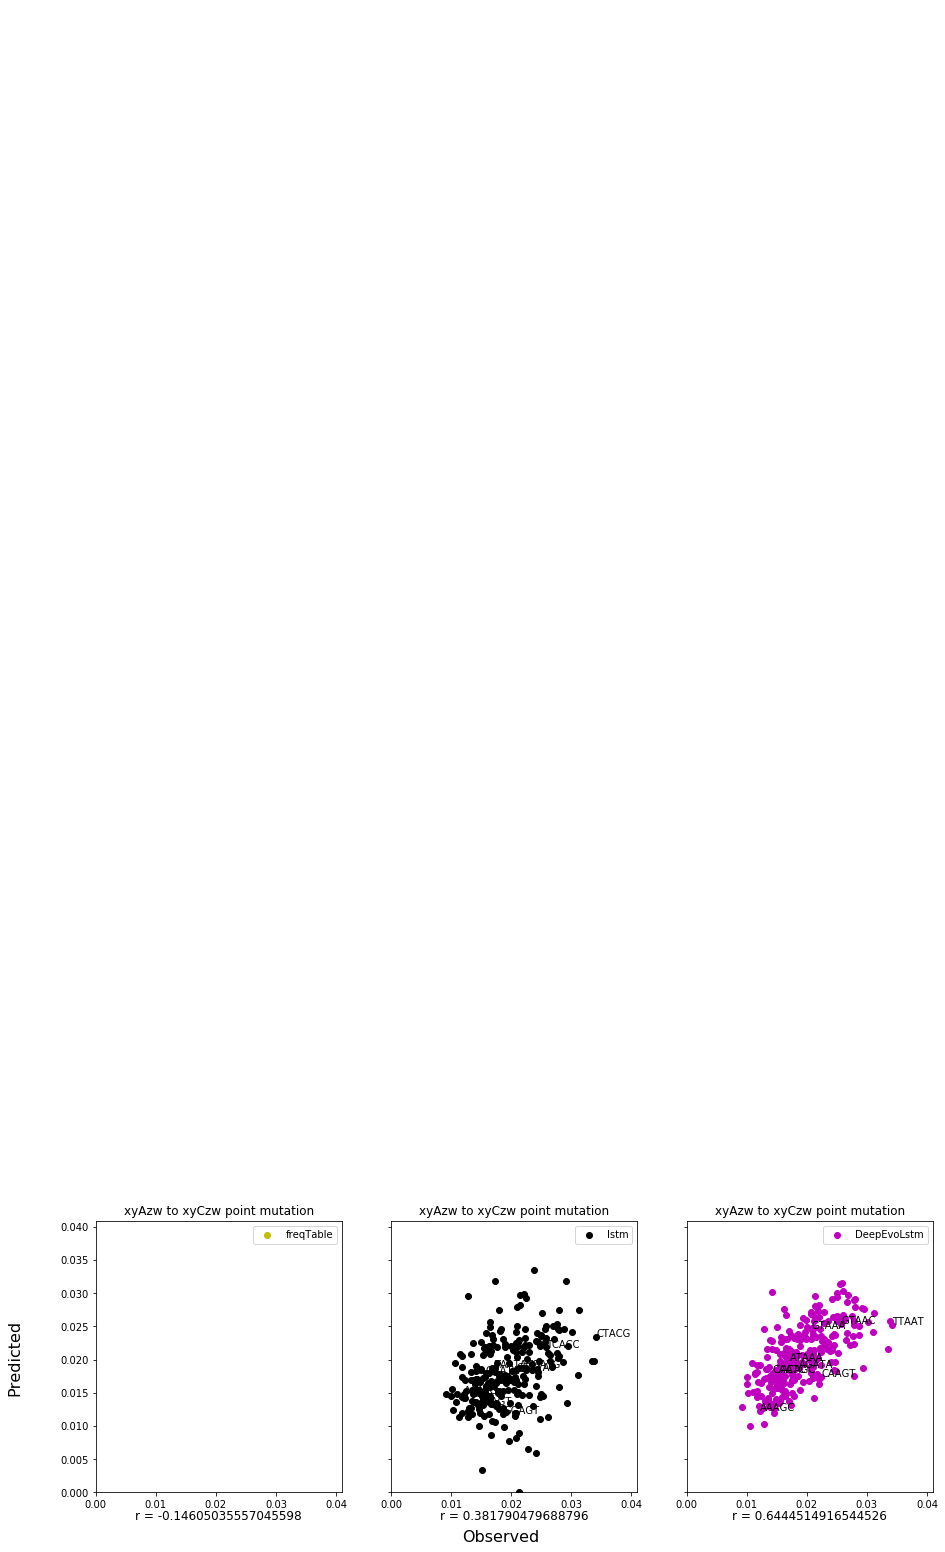

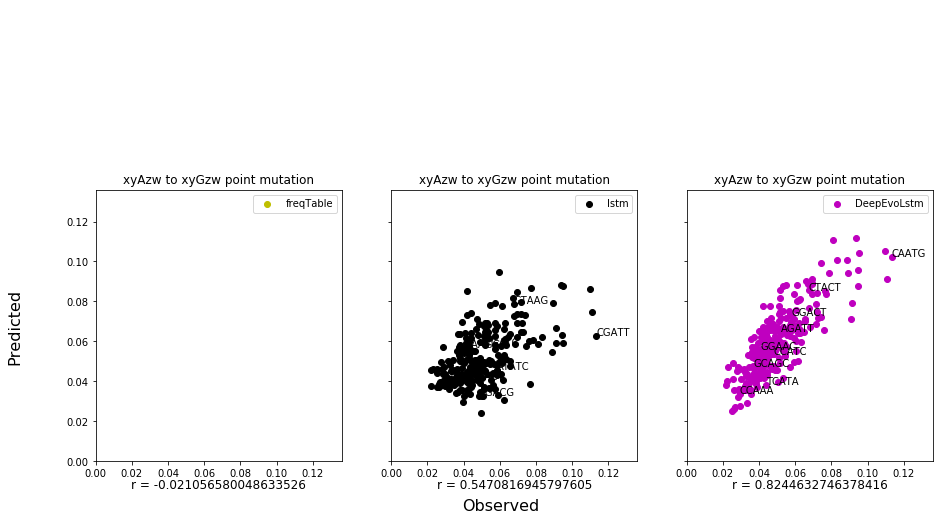

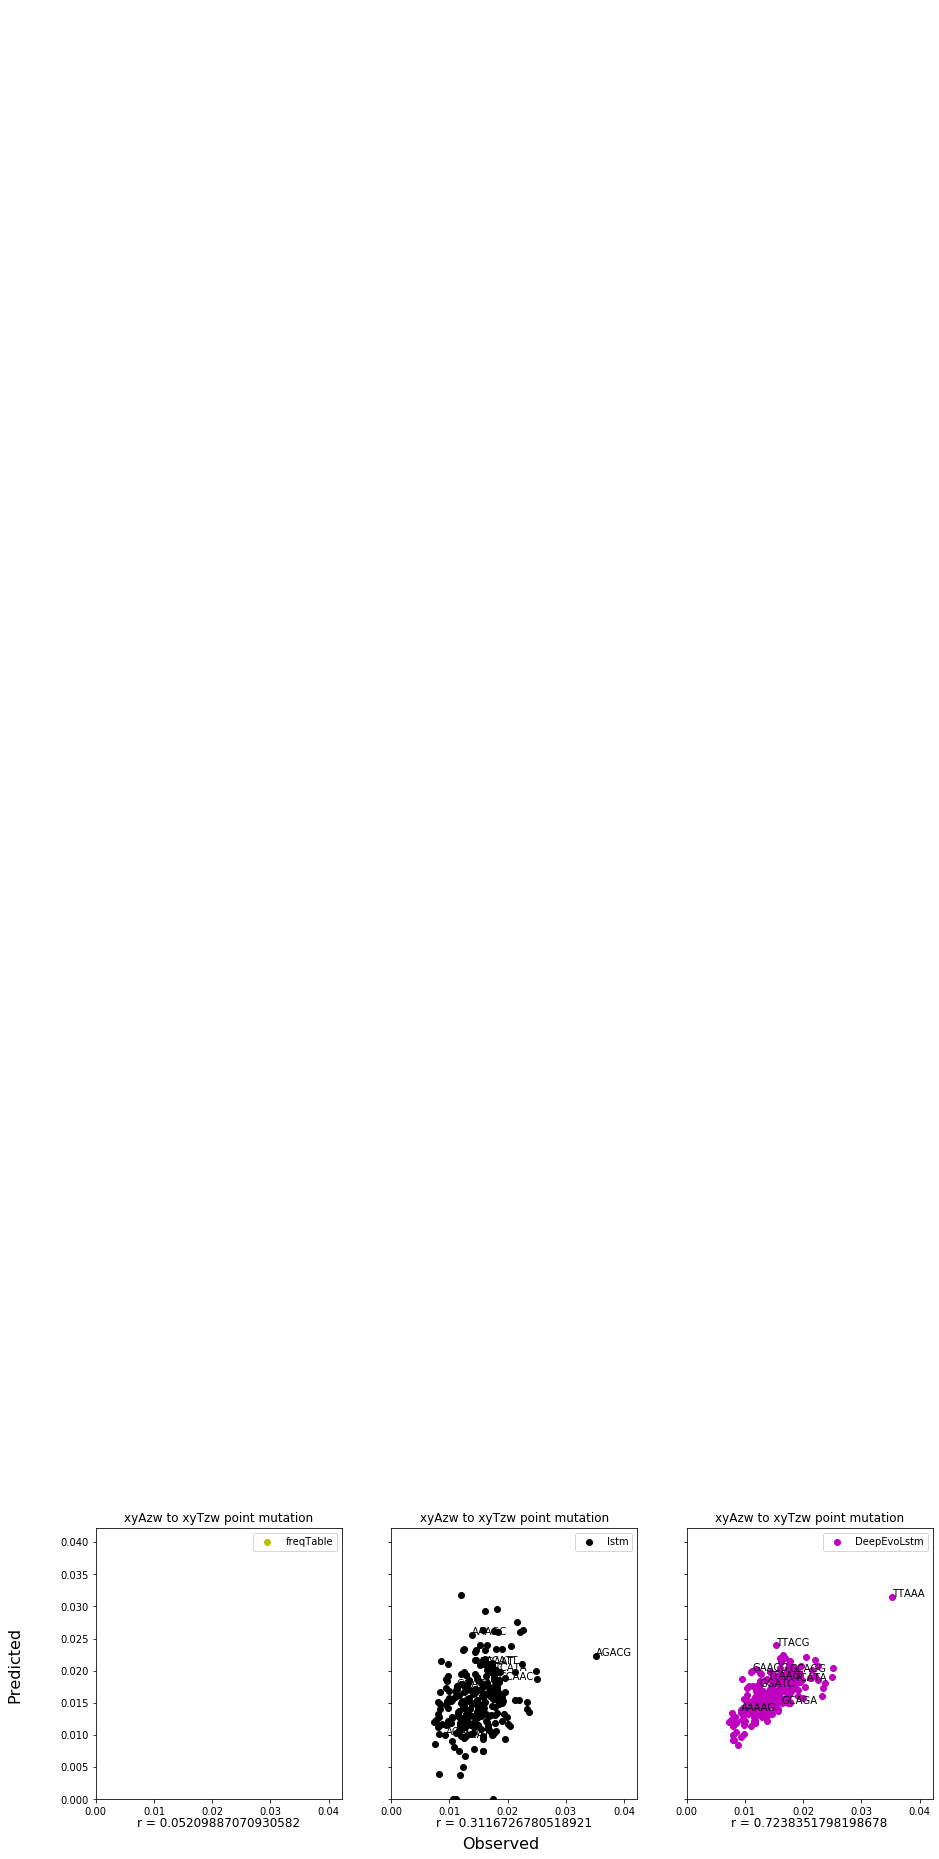

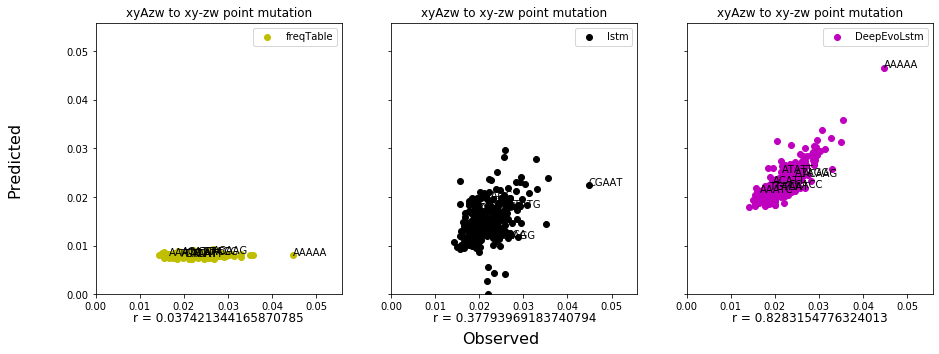

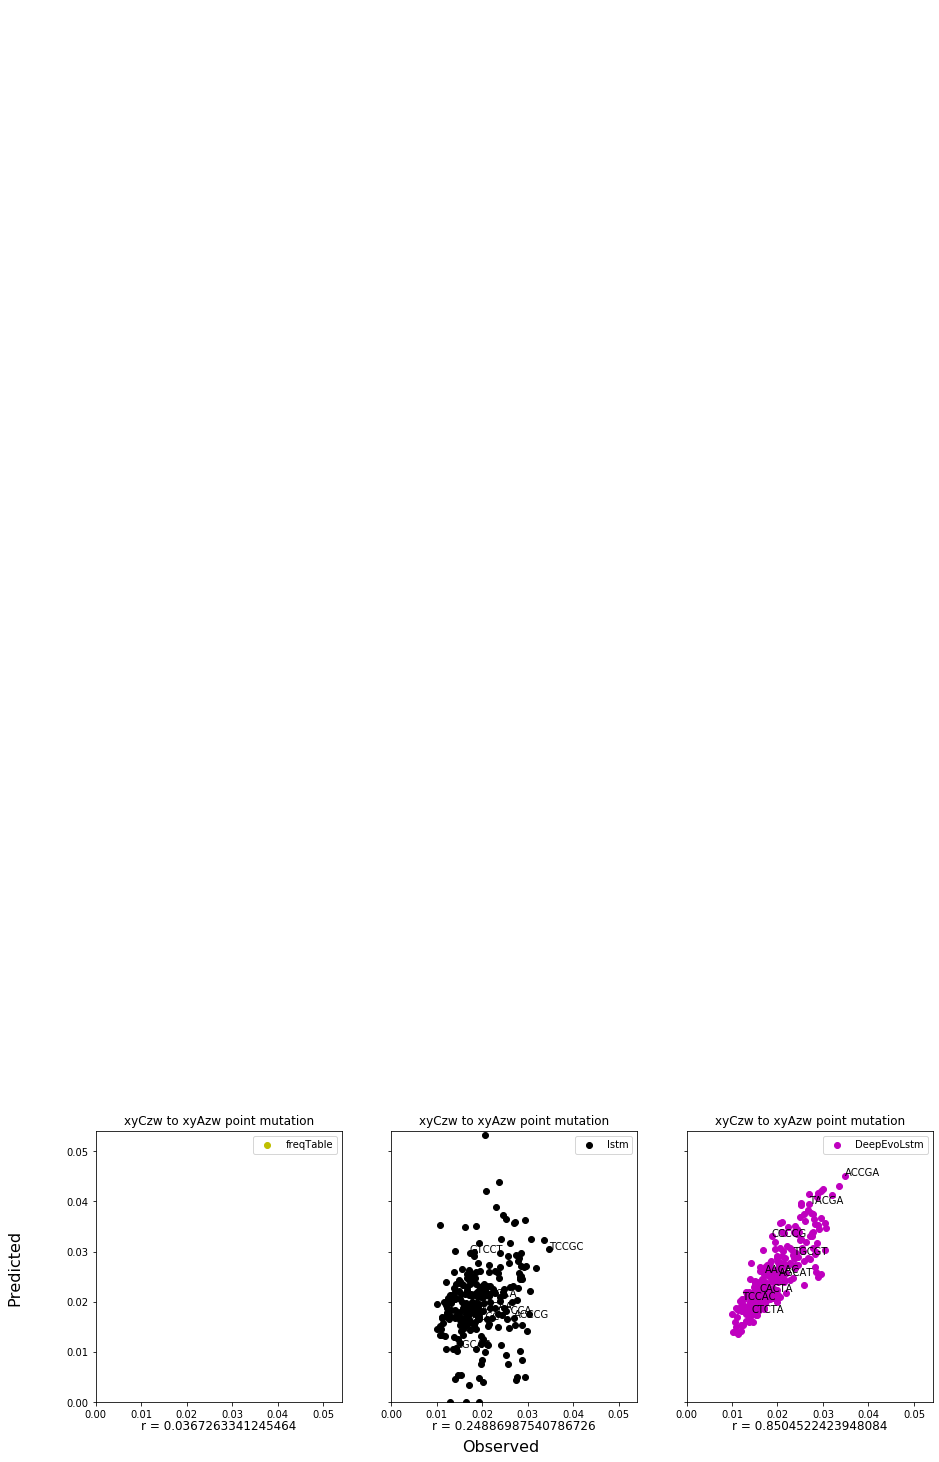

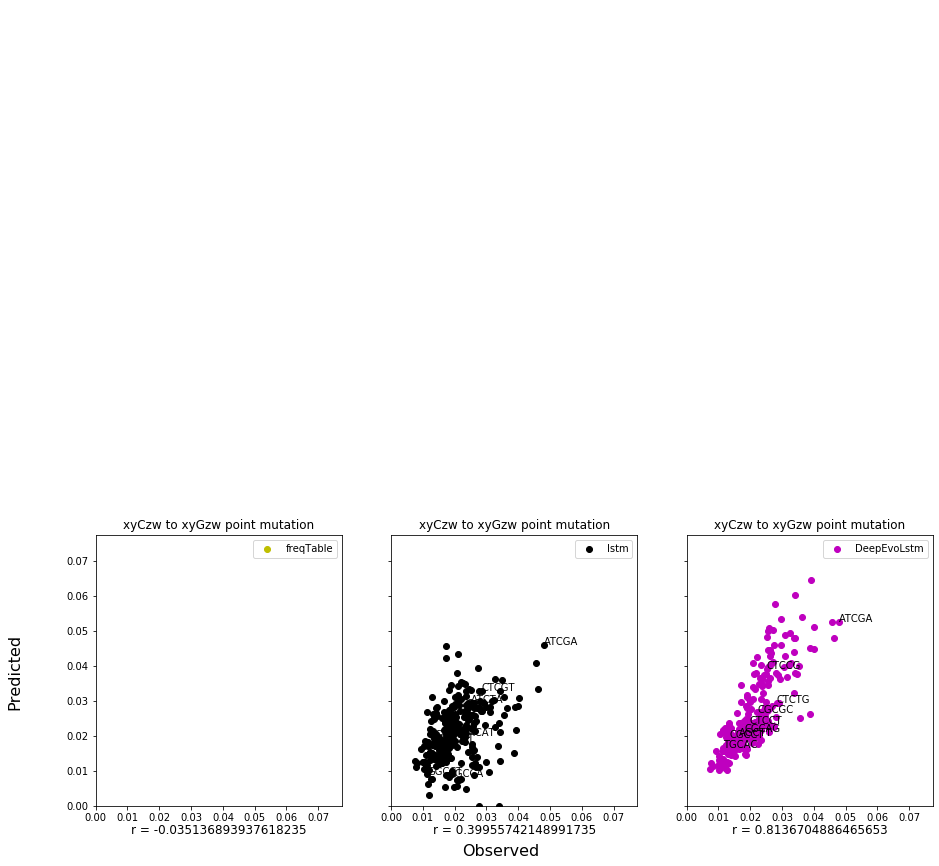

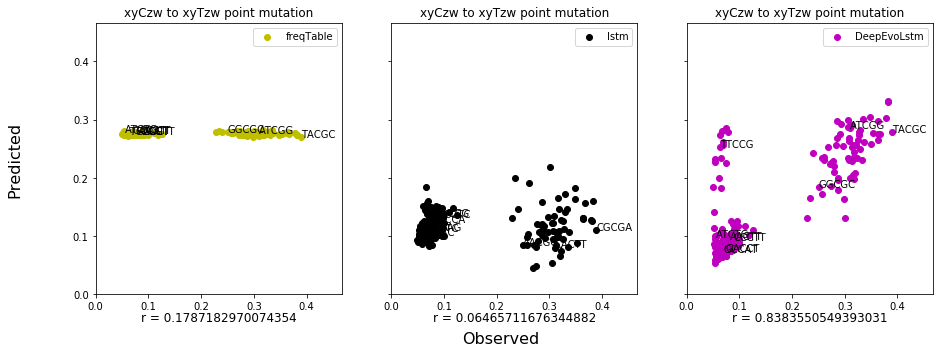

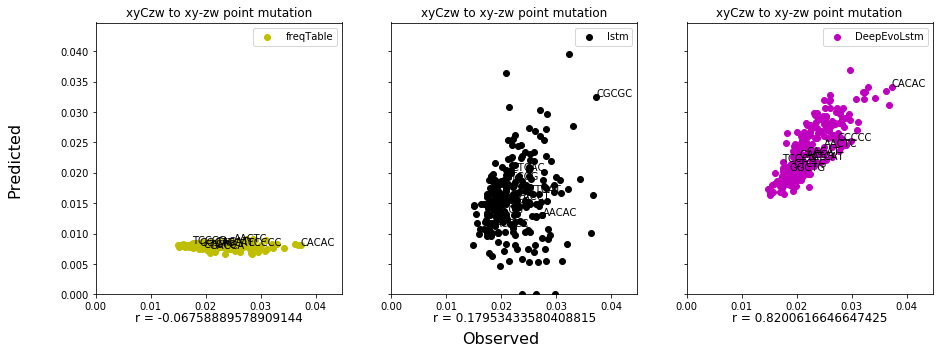

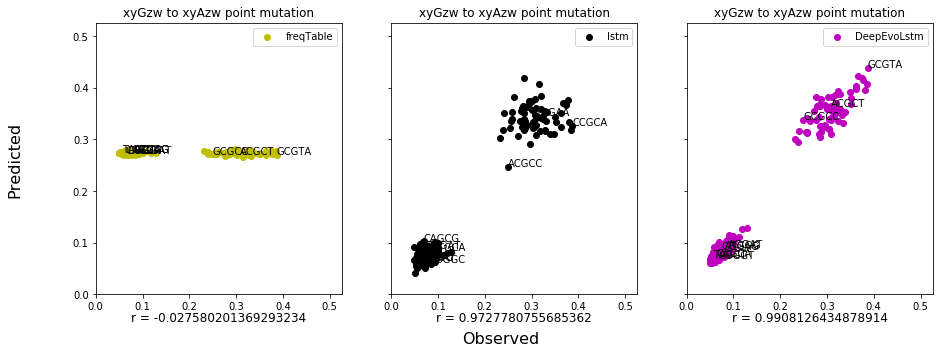

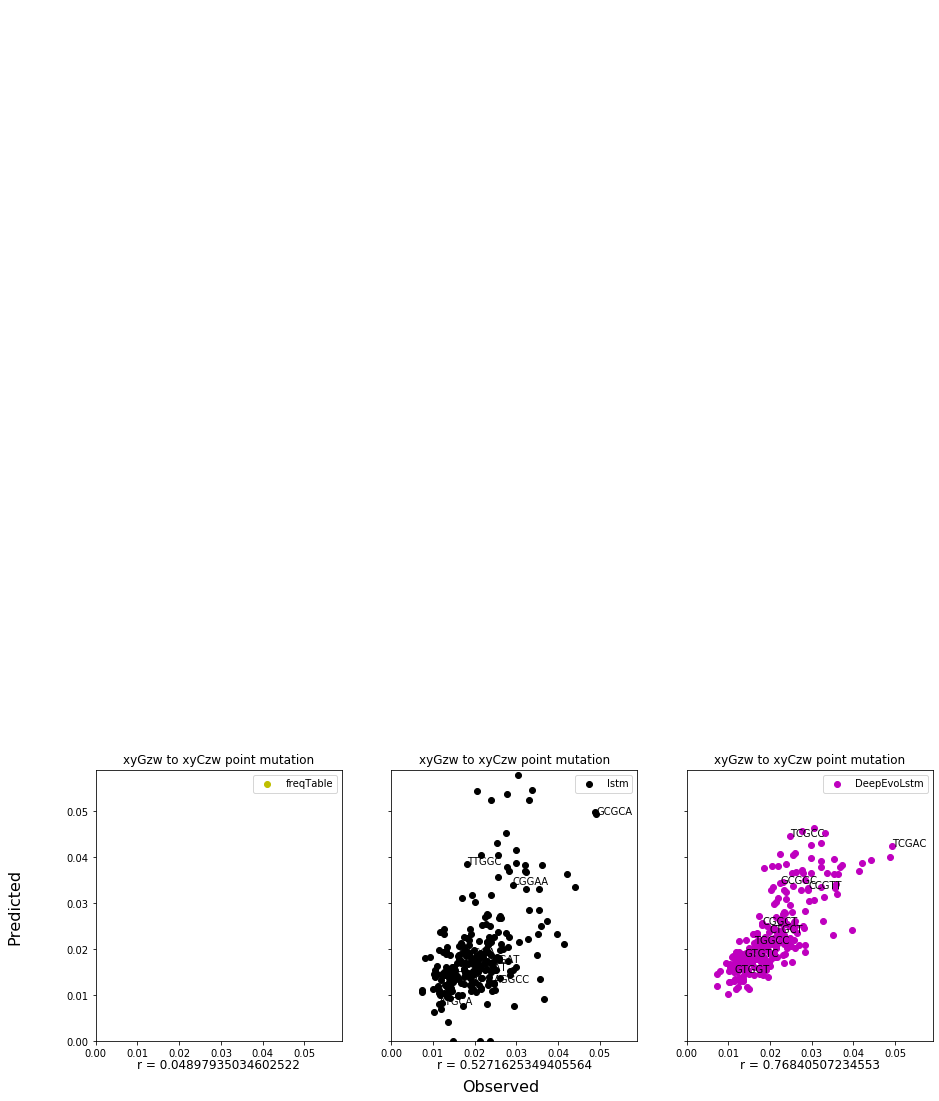

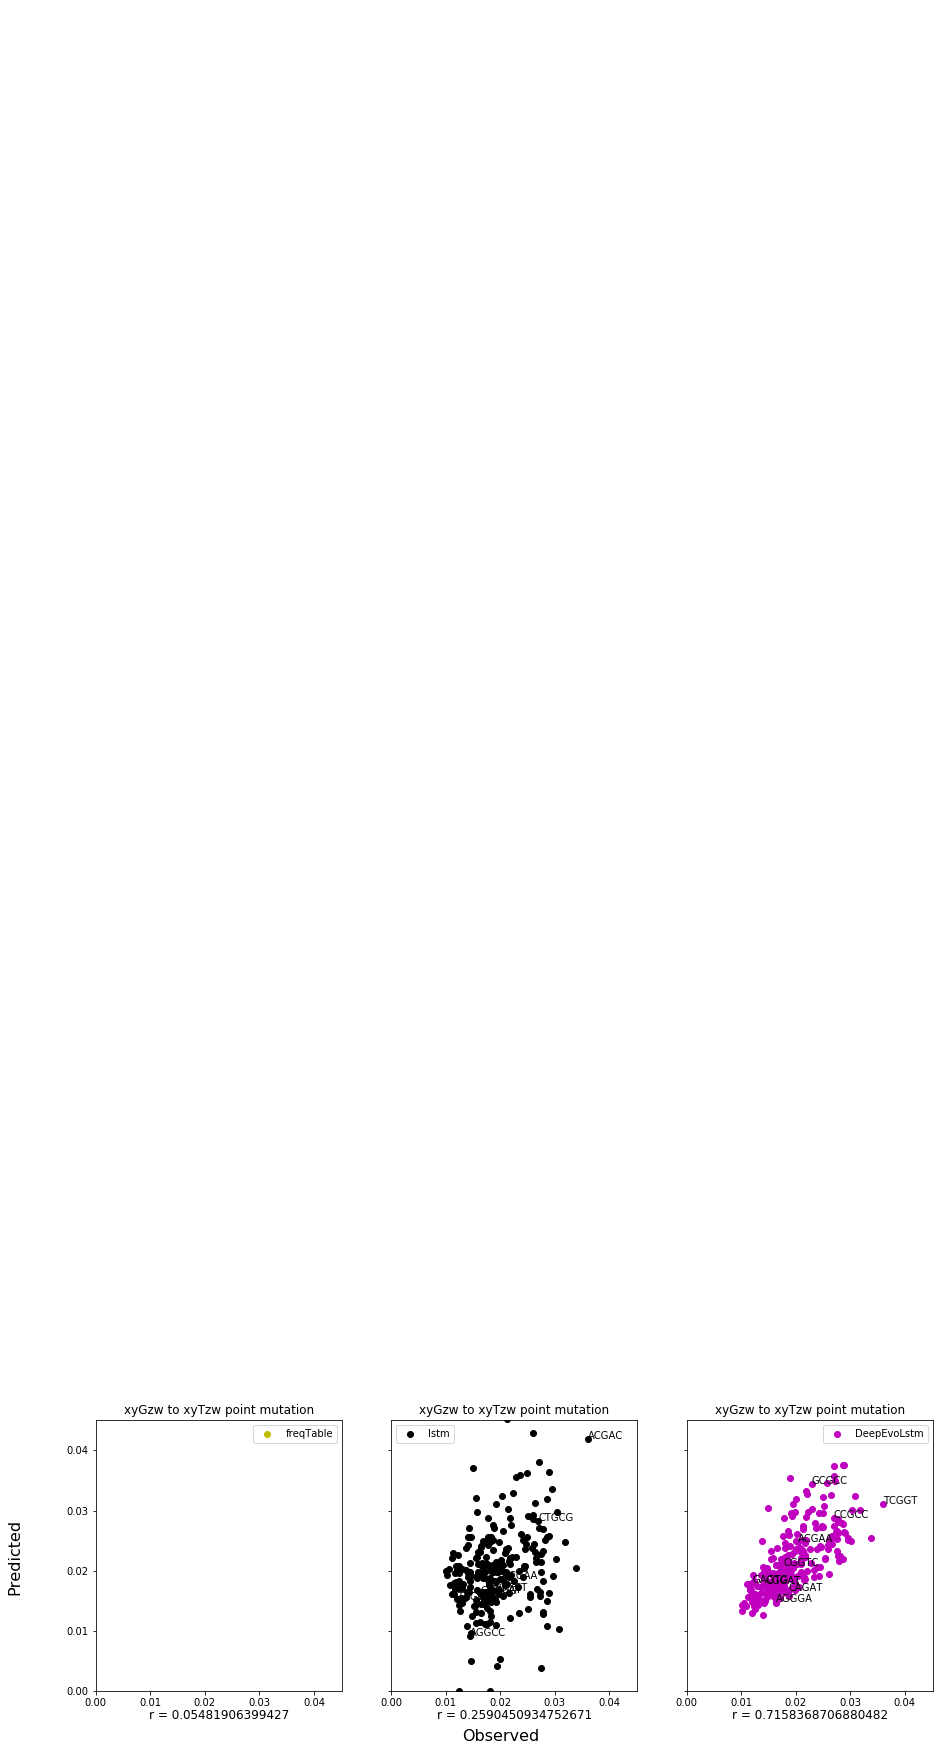

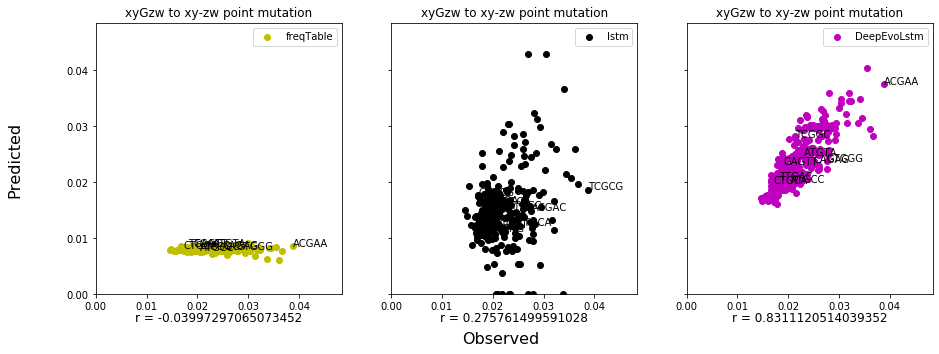

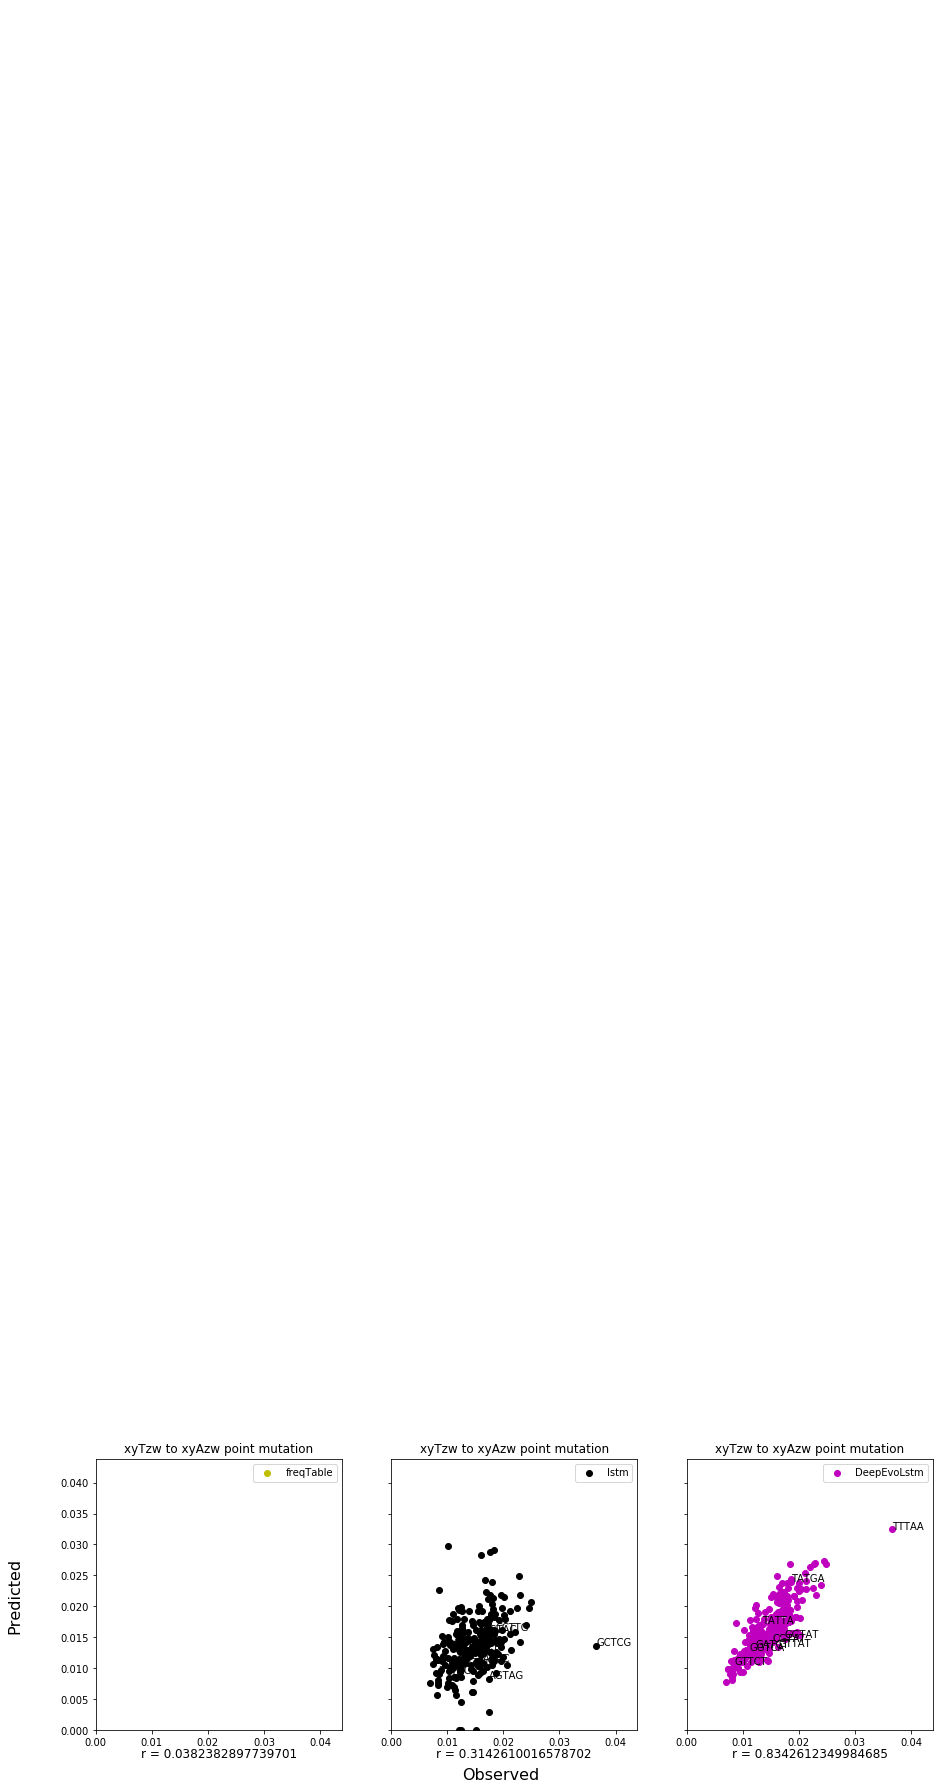

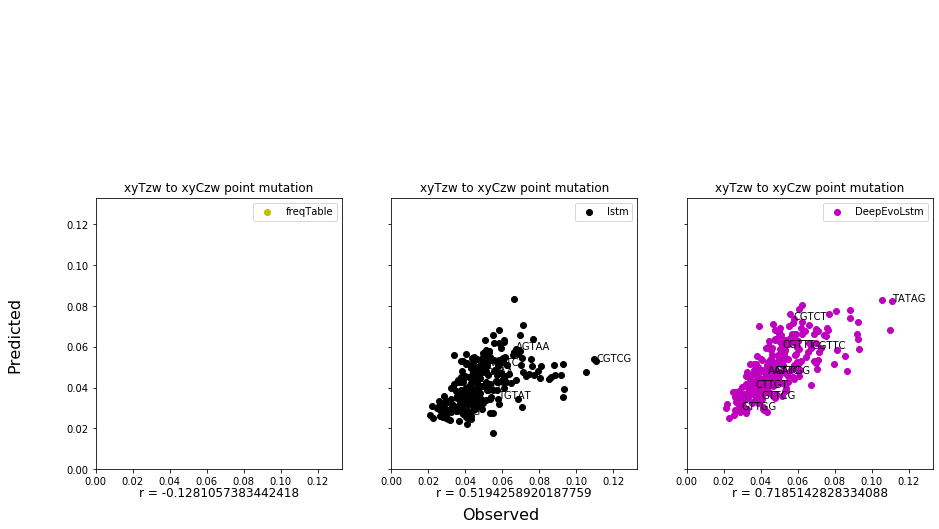

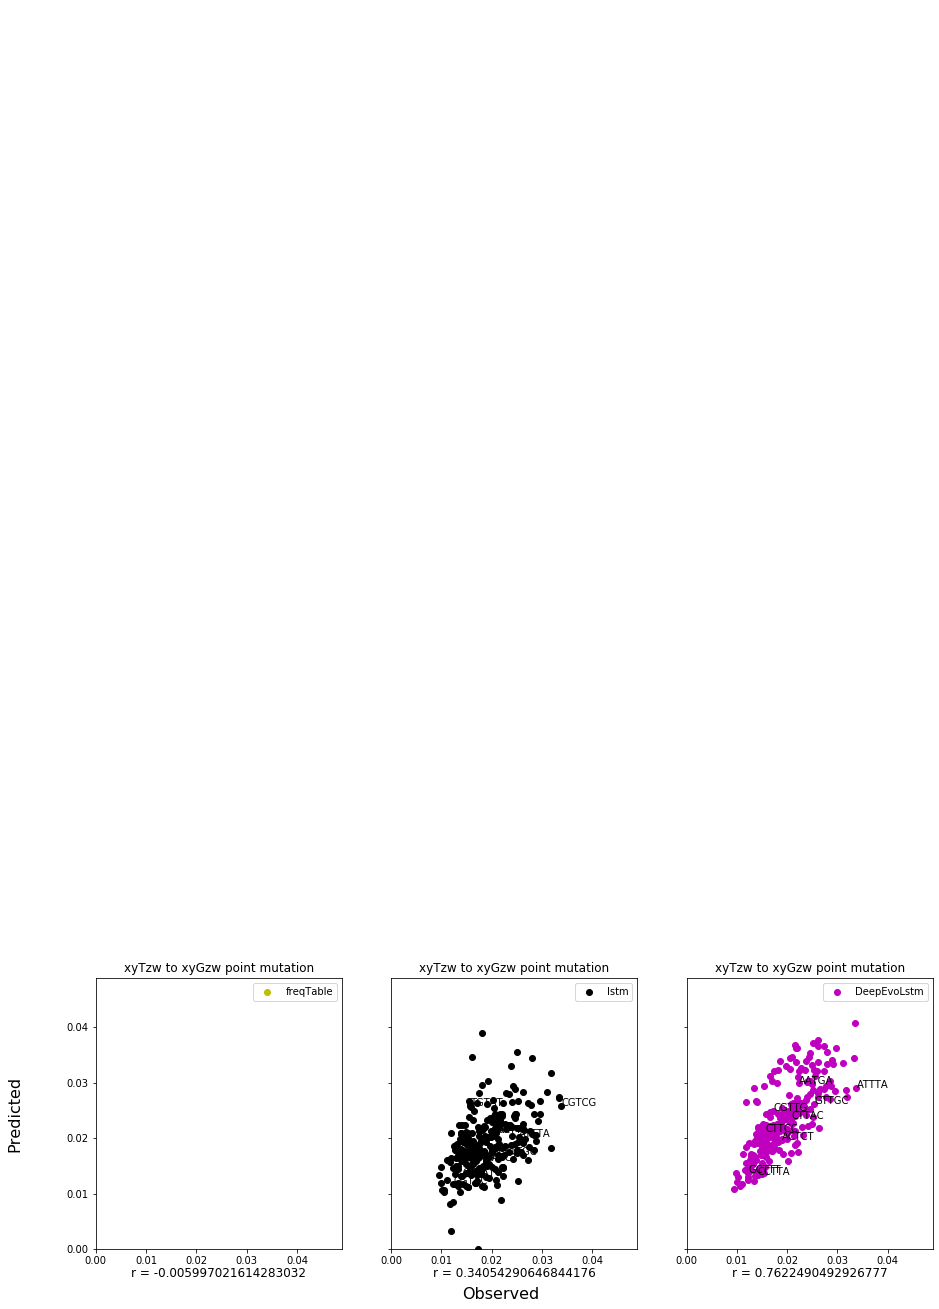

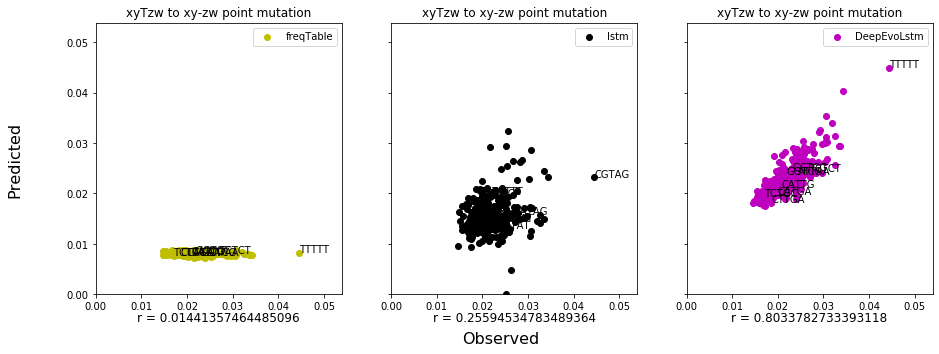

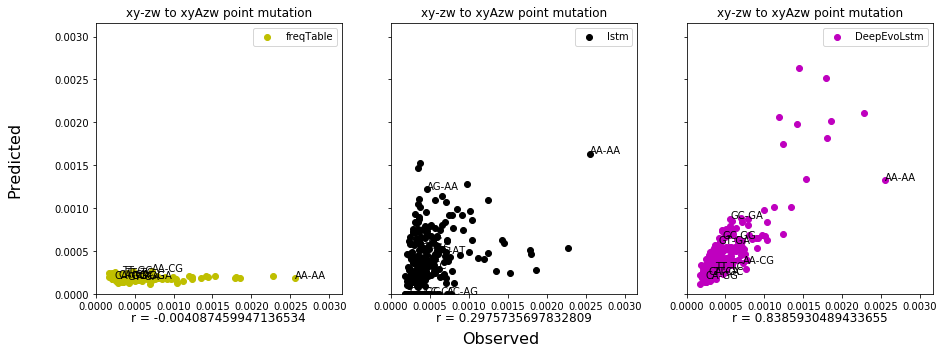

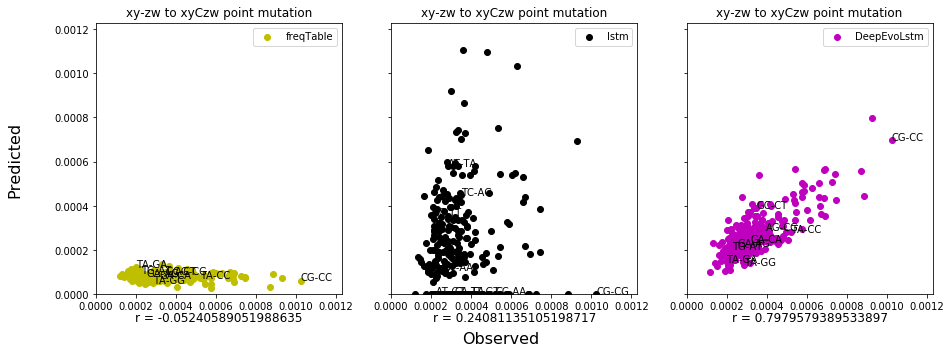

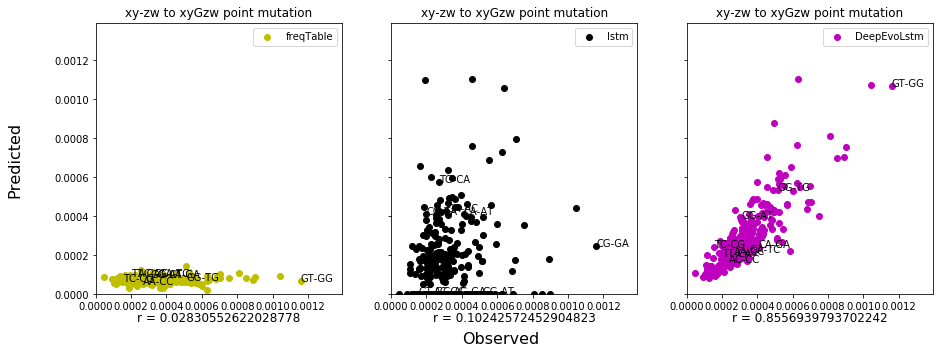

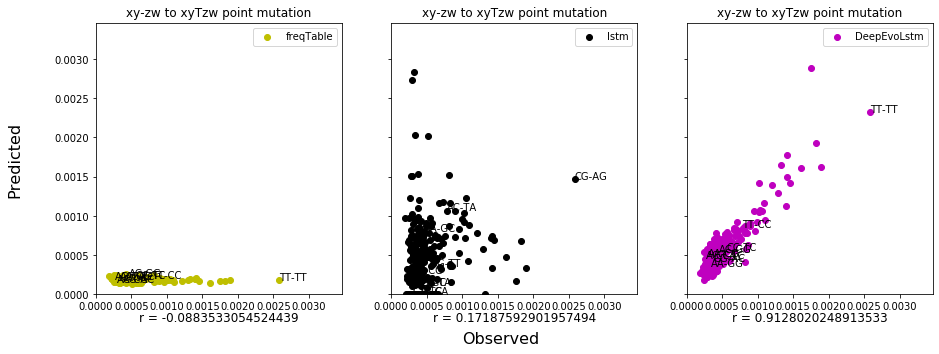

A $rightarrow$ C & 0.644 & 0.382 & -0.146
A $rightarrow$ G & 0.824 & 0.547 & -0.021
A $rightarrow$ T & 0.724 & 0.312 & 0.052
A $rightarrow$ - & 0.828 & 0.378 & 0.037
C $rightarrow$ A & 0.850 & 0.249 & 0.037
C $rightarrow$ G & 0.814 & 0.400 & -0.035
C $rightarrow$ T & 0.838 & 0.065 & 0.179
C $rightarrow$ - & 0.820 & 0.180 & -0.068
G $rightarrow$ A & 0.991 & 0.973 & -0.028
G $rightarrow$ C & 0.768 & 0.527 & 0.049
G $rightarrow$ T & 0.716 & 0.259 & 0.055
G $rightarrow$ - & 0.831 & 0.276 & -0.040
T $rightarrow$ A & 0.834 & 0.314 & 0.038
T $rightarrow$ C & 0.719 & 0.519 & -0.128
T $rightarrow$ G & 0.762 & 0.341 & -0.006
T $rightarrow$ - & 0.803 & 0.256 & 0.014
- $rightarrow$ A & 0.839 & 0.298 & -0.004
- $rightarrow$ C & 0.798 & 0.241 & -0.052
- $rightarrow$ G & 0.856 & 0.102 & 0.028
- $rightarrow$ T & 0.913 & 0.172 & -0.088


In [12]:
# inputAll, inputAll2, predAll, outputAll= decodeList(inputAll, predAll, outputAll)
# lstm_inputAll, lstm_inputAll2, lstm_predAll, lstm_outputAll = decodeList(lstm_inputAll, lstm_predAll, lstm_outputAll)
def plotCombine(k, tableCon):
#     predTable = [str(np.load('predTable_{}.npy'.format(tableCon)))]
#     ancCase = ['A','C','G','T']
#     desCase = ['A','C','G','T','-']
#     for i in tqdm_notebook(ancCase):
#         for j in desCase:
#             contextMut(contextLen, i, j, inputAll, predAll, pred = True, evol = False, tableCon= tableCon)
#             contextMut(contextLen, i, j, inputAll, predTable, pred = True, evol = False, table = 'Table', tableCon= tableCon)
#             contextMut(contextLen, i, j, inputAll, outputAll, pred = False, evol = False, tableCon= tableCon)
#             contextMut(contextLen, i, j, lstm_inputAll, lstm_predAll, pred = True, evol = False, lstm = True, tableCon= tableCon)
#     ancCase = ['-']
#     desCase = ['A','C','G','T']
#     for i in tqdm_notebook(ancCase):
#         for j in desCase:
#             contextMutInsert(contextLen, i, j, inputAll, predAll, pred = True, evol = False, tableCon= tableCon)
#             contextMutInsert(contextLen, i, j, inputAll, predTable, pred = True, evol = False, table = 'Table', tableCon= tableCon)
#             contextMutInsert(contextLen, i, j, inputAll, outputAll, pred = False, evol = False, tableCon= tableCon)
#             contextMutInsert(contextLen, i, j, lstm_inputAll, lstm_predAll, pred = True, evol = False, lstm = True, tableCon= tableCon)

    ancCase = ['A','C','G','T','-']
    desCase = ['A','C','G','T','-']


    value = []
    for i in ancCase:
        for j in desCase:
            if i != j:
                value.append(plotScatter(numBin,i, j, tableCon))
                
    for item in value:
        print(item)

plotCombine(2, 1)

In [7]:
plotCombine(2, 5)


/home/mcb/users/dlim63/miniconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


KeyboardInterrupt: 

In [ ]:
plotCombine(2, 15)


In [ ]:
plotCombine(3, 1)


In [ ]:
plotCombine(3, 5)

In [ ]:
plotCombine(3, 15)

In [ ]:
def analyzeMut(ancNuc, desNuc):
    predSeq = np.load('data/pred_context{}{}_{}.npy'.format(ancNuc,desNuc, ancName), allow_pickle = True).item()
    trueSeq = np.load('data/true_context{}{}_{}.npy'.format(ancNuc,desNuc, ancName), allow_pickle = True).item()
#     evolSeq = np.load('data/true_evol_context{}{}_{}.npy'.format(ancNuc,desNuc, ancName), allow_pickle = True).item()
    lstmSeq = np.load('data/pred_lstm_context{}{}_{}.npy'.format(ancNuc,desNuc, ancName), allow_pickle = True).item()

#     print(list(predSeq.keys())[:256])
#     print(list(trueSeq.keys())[:256])
    print(predSeq)
#     print(trueSeq)
    
analyzeMut('A','G')

In [ ]:
contextLength = 1
numBin = 16
def contextMut(size, ancNuc, desNuc, anc, des, pred, evol, lstm = False):
    cont = list(itertools.product('ACGT', repeat=size))
    cont1 = list(itertools.product('ACGT', repeat=size))
    context_dict = {}
    count_dict = {}
    for i in cont1:
        for j in cont1:
            #context_dict[(''.join(i)+'A'+''.join(j) , ''.join(i)+'G'+''.join(j))] = 0
            context_dict[(''.join(i)+ancNuc+''.join(j))] = 0
            count_dict[(''.join(i)+ancNuc+''.join(j))] = 0
    for a,b in zip(anc, des):
        for i in range(len(a)-size*2-len(ancNuc)):
            if a[i+size:i+size+len(ancNuc)] == ancNuc :
                count_dict[(a[i:i+size*2+len(ancNuc)])] += 1
    for a,b in zip(anc, des):
        for i in range(len(a)-size*2-len(ancNuc)):
            if a[i+size:i+size+len(ancNuc)] == ancNuc and b[i+size+int(len(ancNuc)/2)] == desNuc:
                context_dict[(a[i:i+size*2+len(ancNuc)])] += 1
    for key in context_dict.keys():
        if count_dict[key] !=0:
            context_dict[key] = context_dict[key]/count_dict[key] 
        else :
            continue
    sorted_context = sorted(context_dict.items(), key=operator.itemgetter(1), reverse = 1)
    sorted_context = dict(sorted_context)
    if lstm ==False:
        if pred == True and evol ==False:
            np.save('data/pred_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        elif pred == True and evol == True:
            np.save('data/pred_evol_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        elif pred == False and evol ==False:
            np.save('data/true_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        elif pred == False and evol ==True:
            np.save('data/true_evol_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        return sorted_context
    elif lstm ==True :
        if pred == True:
            np.save('data/pred_lstm_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        elif pred ==False:
            np.save('data/true_lstm_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
    return sorted_context
            
def contextMutInsert(size, ancNuc, desNuc, anc, des, pred, evol, lstm = False):
    cont1 = list(itertools.product('ACGT', repeat=size-1))
    cont = list(itertools.product('ACGT', repeat=size))
    context_dict = {}
    count_dict = {}
    for i in cont:
        for j in cont:
            #context_dict[(''.join(i)+'A'+''.join(j) , ''.join(i)+'G'+''.join(j))] = 0
            context_dict[(''.join(i)+ancNuc+''.join(j))] = 0
            count_dict[(''.join(i)+ancNuc+''.join(j))] = 0
    for a,b in zip(anc, des):
        for i in range(len(a)-size*2-len(ancNuc)):
            count_dict[(a[i:i+size]+ancNuc+a[i+size+len(ancNuc):i+size*2+len(ancNuc)])] += 1
    for a,b in zip(anc, des):
        for i in range(len(a)-size*2-len(ancNuc)):
            inserted_nuc = inv_dict[b[i+size+int(len(ancNuc)/2)-1]]
            if len(inserted_nuc) >1 and inserted_nuc[1] == desNuc:
                context_dict[(a[i:i+size]+ancNuc+a[i+size+len(ancNuc):i+size*2+len(ancNuc)])] += 1
    for key in context_dict.keys():
        if count_dict[key] !=0:
            context_dict[key] = context_dict[key]/count_dict[key] 
        else :
            continue
    sorted_context = sorted(context_dict.items(), key=operator.itemgetter(1), reverse = 1)
    sorted_context = dict(sorted_context)
    if lstm ==False:
        if pred == True and evol ==False:
            np.save('data/pred_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        elif pred == True and evol == True:
            np.save('data/pred_evol_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        elif pred == False and evol ==False:
            np.save('data/true_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        elif pred == False and evol ==True:
            np.save('data/true_evol_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        return sorted_context
    elif lstm ==True :
        if pred == True:
            np.save('data/pred_lstm_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
        elif pred ==False:
            np.save('data/true_lstm_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), sorted_context)
    return sorted_context
            
def calculateR(contextLen, ancCase, desCase):
    sorted_context = contextMut(contextLen, ancCase, desCase, inputAll, predAll, pred = True, evol = False)
    contextMut(contextLen, ancCase, desCase, inputAll, outputAll, pred = False, evol = False)
    contextMut(contextLen, ancCase, desCase, lstm_inputAll, lstm_predAll, pred = True, evol = False, lstm = True)

    sorted_word = list(sorted_context.keys())
    top = sorted_word[0]
    mid = sorted_word[int(len(sorted_word)/2)]
    bot = sorted_word[-1]
    return top, mid, bot

def calculateRInsert(contextLen, ancCase, desCase):
    sorted_context = contextMutInsert(contextLen, ancCase, desCase, inputAll, predAll, pred = True, evol = False)
    contextMutInsert(contextLen, ancCase, desCase, inputAll, outputAll, pred = False, evol = False)
    contextMutInsert(contextLen, ancCase, desCase, lstm_inputAll, lstm_predAll, pred = True, evol = False, lstm = True)

    sorted_word = list(sorted_context.keys())
    top = sorted_word[0]
    mid = sorted_word[int(len(sorted_word)/2)]
    bot = sorted_word[-1]
    return top, mid, bot
    
def plotContextChange(contLen, ancCase, desCase, insert = False):
    contextLen = contLen
    if insert == True:
        top, mid, bot = calculateRInsert(contextLen, ancCase, desCase)
        
        tt, tm, tb = calculateRInsert(contextLen, top, desCase)
        mt, mm, mb = calculateRInsert(contextLen, mid, desCase)
        bt, bm, bb = calculateRInsert(contextLen, bot, desCase)

        ttt, ttm, ttb = calculateRInsert(contextLen, tt, desCase)
        mmt, mmm, mmb = calculateRInsert(contextLen, mm, desCase)
        bbt, bbm, bbb = calculateRInsert(contextLen, bb, desCase)
    else :
        top, mid, bot = calculateR(contextLen, ancCase, desCase)
        tt, tm, tb = calculateR(contextLen, top, desCase)
        mt, mm, mb = calculateR(contextLen, mid, desCase)
        bt, bm, bb = calculateR(contextLen, bot, desCase)

        ttt, ttm, ttb = calculateR(contextLen, tt, desCase)
        mmt, mmm, mmb = calculateR(contextLen, mm, desCase)
        bbt, bbm, bbb = calculateR(contextLen, bb, desCase)
    
    
    topList = [ancCase, top, tt]
    midList = [ancCase, mid, mm]
    botList = [ancCase, bot, bb]
    ancWords = [topList, midList, botList]
    
#     topList =    ['A', 'CAT', 'CCATG']
#     midList = ['A', 'AAC', 'AAACT']
#     botList =['A', 'GAA', 'TGAAA']
#     ancWords =[['A', 'CAT', 'CCATG'], ['A', 'AAC', 'AAACT'], ['A', 'GAA', 'TGAAA']]
    print(topList)
    print(midList)
    print(botList)
    print(ancWords)
   #     lstmSeq = np.load('data/pred_lstm_context{}->{}_{}.npy'.format(ancNuc,desNuc,ancName), allow_pickle = True).item()

    
    f, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(15,15))
    axs = axs.flatten()
    f.text(0.5, 0.08, 'Observed', ha='center', va='center', fontsize=15)
    f.text(0.05, 0.5, 'Predicted', ha='center', va='center', rotation='vertical', fontsize=15)
    f.suptitle('Effect of adding flanking base contexts to {}->{} mutation'.format(ancCase, desCase), fontsize =20)

    index = 0
    for words in tqdm(ancWords):
        for j in desCase:
            for n, i in enumerate(words):
                if i != j:
                    predSeq = np.load('data/pred_context{}->{}_{}.npy'.format(i,j,ancName), allow_pickle = True).item()
                    trueSeq = np.load('data/true_context{}->{}_{}.npy'.format(i,j,ancName), allow_pickle = True).item()
                    true = list(trueSeq.values())
                    true_context = list(trueSeq.keys())
                    pred = []
                    for x in true_context:
                        pred.append(predSeq[x])
                    axs[index].scatter(true, pred, color = 'm')
#                     axs[index].axis('scaled')
#                     axs[index].axis('square')
                    axs[index].set_xlim([0, 1.1 * max(max(pred), max(true))])
                    axs[index].set_ylim([0, 1.1 * max(max(pred), max(true))])
                    axs[index].text(0.5,-0.1, "r = {}".format(stats.pearsonr(pred, true)[0]), size=12, ha="center", 
                             transform=axs[index].transAxes)
                    axs[index].set_title('x{}y to {} point mutation'.format(i, j), fontsize=15)
                    for i, txt in enumerate(list(trueSeq.keys())):
                        if i %3 ==0 or i%(int(len(true)/2))==0:
                            axs[index].annotate(txt, (true[i], pred[i]))

                    index += 1
                    f.savefig('figures/scatter_conChange_{}_{}_{}->{}.png'.format(ancName, desName,  ancCase, desCase))
#                     print('pearson corr: ', stats.pearsonr(pred, true)[0])
    plt.show()
    plt.close()
#                     plotPointMut(numBin,i, j)
#                     plotScatter(numBin,i, j)
#     analyzeMut(ancCase[0],desCase[0])

In [ ]:
plotContextChange(1, 'A', 'G', insert = False)
plotContextChange(1, 'C', 'T', insert = False)
plotContextChange(1, 'C', '-', insert = False)
plotContextChange(1, '-', 'T', insert = True)

In [ ]:
analyzeMut('TAG','G')
contextMut(contextLen, 'TAG', 'G', inputAll, predAll, pred = True, evol = False)